In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import time
begin = time.time()

# DATASET CREATION

In [2]:
#creates a sequence of length between 2 and 15---------------
def create_sequence():
    size_of_input = torch.randint(2, 10, (1,))
    input_ = torch.rand(size_of_input,2)
    num1 = torch.randint(0, size_of_input[0], size=(1,))
    num2 = torch.randint(0, size_of_input[0], size=(1,))
    if num1 == num2 :
        if num1 == 0 :
            num2 = num2+1
        elif num2 == size_of_input-1:
            num2 = num2-1
    for i in range(size_of_input):
        if i==num1 or i==num2 :
            input_[i][1] = 1
        else :
            input_[i][1] = 0
    
    return input_
#-------------------------------------------------------------

#creates a label according to the question--------------------
def create_label(point):
    label = 0
    count = 0 
    for i in range(point.size(0)):
        if(count == 2):
            break ;
        elif(point[i][1] == 1):
            label = label+point[i][0]
            count = count + 1
    return label
#--------------------------------------------------------------

#creates datapoints--------------------------------------------
def create_data(total_points):
    points = torch.empty(total_points,15,2)
    points_label = torch.empty(total_points,1)
    for i in range(total_points):
        input_ = create_sequence()
        output_ = create_label(input_)
        points_label[i][0] = output_
        size = input_.size(0)
        padded_input = torch.nn.functional.pad(input_, (0, 0, 0,(15-size)), mode='constant', value=-1)
        points[i,:,:] = padded_input
    return points,points_label
#---------------------------------------------------------------

**Training and Testing set**

In [3]:
train_set,train_label = create_data(6000)
test_set,test_label = create_data(3000)


In [4]:
train_set[0],train_label[0]

(tensor([[ 0.8917,  0.0000],
         [ 0.4167,  0.0000],
         [ 0.0722,  0.0000],
         [ 0.5723,  1.0000],
         [ 0.8644,  0.0000],
         [ 0.7592,  0.0000],
         [ 0.5142,  1.0000],
         [ 0.5646,  0.0000],
         [ 0.3167,  0.0000],
         [-1.0000, -1.0000],
         [-1.0000, -1.0000],
         [-1.0000, -1.0000],
         [-1.0000, -1.0000],
         [-1.0000, -1.0000],
         [-1.0000, -1.0000]]),
 tensor([1.0865]))

# RNN

In [5]:
class RNN(nn.Module):
    def __init__(self,hidden_size):
        super().__init__()
        self.U = nn.Parameter(torch.randn((hidden_size,2),
                                           requires_grad=True,
                                           dtype=torch.float)/np.sqrt(2))
        self.h = torch.zeros((hidden_size,1),
                                        dtype=torch.float)
        self.W = nn.Parameter(torch.randn((hidden_size,hidden_size),
                                        requires_grad=True,
                                        dtype=torch.float)/np.sqrt(hidden_size))
        self.b = nn.Parameter(torch.zeros((hidden_size,1),
                                        requires_grad=True,
                                        dtype=torch.float))
        self.c = nn.Parameter(torch.rand((1,1),
                                        requires_grad=True,
                                        dtype=torch.float))
        self.V = nn.Parameter(torch.randn((1,hidden_size),
                                        requires_grad=True,
                                        dtype=torch.float)/np.sqrt(hidden_size))
    def forward(self,x: torch.Tensor) -> torch.Tensor: # x is the input data
        y = torch.empty(x.size(0),1)
        for j in range(x.size(0)):
            H = self.h
            for i in range(x.size(1)):
                if(x[j][i][0] == -1):
                    break ;
                I = torch.matmul(self.U,x[j,i,:].T).unsqueeze(1)
                O = torch.matmul(self.W,H)
                H = (I + O + self.b)
                H  =torch.tanh(H)
            Y = torch.matmul(self.V,H) + self.c
            y[j,:] = torch.relu(Y)
        return y

In [6]:
model_1 = RNN(5)#instatiating an object for RNN class
model_1.h

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [7]:
list(model_1.parameters())

[Parameter containing:
 tensor([[ 0.3311, -0.0858],
         [ 0.2456, -1.2341],
         [-1.3302,  0.8481],
         [ 0.6624,  0.0563],
         [-0.0411,  0.3115]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.6050,  0.1413, -0.8601, -0.3058,  0.4131],
         [-0.6139,  0.4561,  0.9732, -0.5014,  0.3434],
         [ 0.8125, -0.5529,  0.1972,  0.1168,  0.5531],
         [ 0.0542, -0.6784,  0.1695,  0.2952, -0.1296],
         [ 0.1278, -0.2069,  0.2728, -0.4752, -0.0931]], requires_grad=True),
 Parameter containing:
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]], requires_grad=True),
 Parameter containing:
 tensor([[0.1604]], requires_grad=True),
 Parameter containing:
 tensor([[-0.4147, -0.9810,  0.3185,  0.1710,  0.5520]], requires_grad=True)]

In [8]:
y_pred = model_1(train_set)
y_pred,train_label

/tmp/ipykernel_5784/3677997783.py:28: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  I = torch.matmul(self.U,x[j,i,:].T).unsqueeze(1)


(tensor([[1.0970],
         [1.1501],
         [1.2984],
         ...,
         [1.7362],
         [1.1003],
         [1.3893]], grad_fn=<CopySlices>),
 tensor([[1.0865],
         [1.0197],
         [1.2747],
         ...,
         [0.2136],
         [0.9517],
         [1.8013]]))

In [9]:
#LOSS - MSELoss-----------------
loss_fn = nn.MSELoss()
#-------------------------------

#SGD optimizer------------------------------------------------------
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.05)
#--------------------------------------------------------------------

In [10]:
# y_pred = model_1(train_set)
base_line_loss = loss_fn(train_label,torch.ones_like(train_label))
base_line_loss = base_line_loss.detach()
base_line_loss

tensor(0.1844)

In [11]:
epochs = 50
rnn_loss_epoch = []
epoch_count = []
base_line = []
#training loop
for epoch in range(epochs):
    model_1.train()
    y_pred = model_1(train_set)
    loss = loss_fn(y_pred,train_label)
    rnn_loss_epoch.append(loss.clone().detach())
    epoch_count.append(epoch)
    base_line.append(base_line_loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()                      
    print(f"Epoch: {epoch} | Train Loss : {loss} ")


Epoch: 0 | Train Loss : 0.5060364007949829 
Epoch: 1 | Train Loss : 0.31902605295181274 
Epoch: 2 | Train Loss : 0.23073138296604156 
Epoch: 3 | Train Loss : 0.21576713025569916 
Epoch: 4 | Train Loss : 0.20381653308868408 
Epoch: 5 | Train Loss : 0.1927611529827118 
Epoch: 6 | Train Loss : 0.19025419652462006 
Epoch: 7 | Train Loss : 0.18750028312206268 
Epoch: 8 | Train Loss : 0.18203523755073547 
Epoch: 9 | Train Loss : 0.18060000240802765 
Epoch: 10 | Train Loss : 0.18095609545707703 
Epoch: 11 | Train Loss : 0.17852970957756042 
Epoch: 12 | Train Loss : 0.17630507051944733 
Epoch: 13 | Train Loss : 0.17663364112377167 
Epoch: 14 | Train Loss : 0.17616623640060425 
Epoch: 15 | Train Loss : 0.1740042269229889 
Epoch: 16 | Train Loss : 0.17302769422531128 
Epoch: 17 | Train Loss : 0.17297640442848206 
Epoch: 18 | Train Loss : 0.1716776341199875 
Epoch: 19 | Train Loss : 0.17015643417835236 
Epoch: 20 | Train Loss : 0.16990704834461212 
Epoch: 21 | Train Loss : 0.1694672852754593 
Epo

In [12]:
y_pred = model_1(test_set)
rnn_test_loss = loss_fn(y_pred,test_label)
print(f"after {epochs} Epochs , Test Loss : {rnn_test_loss}")

after 50 Epochs , Test Loss : 0.14573055505752563


# LSTM

In [13]:
class LSTM(nn.Module):
    def __init__(self,hidden_size):
        super().__init__()
        self.h0 = torch.zeros((hidden_size,1),
                                        dtype=torch.float)
        self.c0 = torch.zeros((hidden_size,1),
                                        dtype=torch.float)
        self.Uf = nn.Parameter(torch.randn((hidden_size,2),
                                           requires_grad=True,
                                           dtype=torch.float)/np.sqrt(2))
        self.Wf = nn.Parameter(torch.randn((hidden_size,hidden_size),
                                        requires_grad=True,
                                        dtype=torch.float)/np.sqrt(hidden_size))
        self.bf = nn.Parameter(torch.zeros((hidden_size,1),
                                        requires_grad=True,
                                        dtype=torch.float))
        self.Ui = nn.Parameter(torch.randn((hidden_size,2),
                                           requires_grad=True,
                                           dtype=torch.float)/np.sqrt(2))
        self.Wi = nn.Parameter(torch.randn((hidden_size,hidden_size),
                                        requires_grad=True,
                                        dtype=torch.float)/np.sqrt(hidden_size))
        self.bi = nn.Parameter(torch.zeros((hidden_size,1),
                                        requires_grad=True,
                                        dtype=torch.float))
        self.Uo = nn.Parameter(torch.randn((hidden_size,2),
                                           requires_grad=True,
                                           dtype=torch.float)/np.sqrt(2))
        self.Wo = nn.Parameter(torch.randn((hidden_size,hidden_size),
                                        requires_grad=True,
                                        dtype=torch.float)/np.sqrt(hidden_size))
        self.bo = nn.Parameter(torch.zeros((hidden_size,1),
                                        requires_grad=True,
                                        dtype=torch.float))
        self.V = nn.Parameter(torch.randn((1,hidden_size),
                                        requires_grad=True,
                                        dtype=torch.float)/np.sqrt(hidden_size))
        self.b = nn.Parameter(torch.rand((1,1),
                                        requires_grad=True,
                                        dtype=torch.float))
        self.bc = nn.Parameter(torch.zeros((hidden_size,1),
                                        requires_grad=True,
                                        dtype=torch.float))
        self.Wc = nn.Parameter(torch.randn((hidden_size,hidden_size),
                                           requires_grad=True,
                                           dtype=torch.float)/np.sqrt(hidden_size))
        self.Uc = nn.Parameter(torch.randn((hidden_size,2),
                                           requires_grad=True,
                                           dtype=torch.float)/np.sqrt(2))
        
    def forward(self,x: torch.Tensor) -> torch.Tensor: # x is the input data
        y = torch.empty(x.size(0),1)
        for j in range(x.size(0)):
            H = self.h0
            C = self.c0
            for i in range(x.size(1)):
                if(x[j][i][0] == -1):
                    break ;
                F = torch.sigmoid(torch.matmul(self.Uf,x[j,i,:].T).unsqueeze(1) + torch.matmul(self.Wf,H) + self.bf)
                I = torch.sigmoid(torch.matmul(self.Ui,x[j,i,:].T).unsqueeze(1) + torch.matmul(self.Wi,H) + self.bi)
                O = torch.sigmoid(torch.matmul(self.Uo,x[j,i,:].T).unsqueeze(1) + torch.matmul(self.Wo,H) + self.bo)
                C_ = torch.tanh(torch.matmul(self.Uc,x[j,i,:].T).unsqueeze(1) + torch.matmul(self.Wc,H) + self.bc)
                C = torch.mul(F,C) + torch.mul(I,C_)
                H = torch.mul(O,torch.tanh(C))
            Y = torch.matmul(self.V,H) + self.b
            y[j,:] = torch.relu(Y)
        return y

In [14]:
model_2 = LSTM(5)

In [15]:
list(model_2.parameters())

[Parameter containing:
 tensor([[-0.0429, -0.0737],
         [-1.5177, -0.9322],
         [ 0.1839,  0.5235],
         [ 1.3104,  0.6136],
         [ 0.3485,  1.2686]], requires_grad=True),
 Parameter containing:
 tensor([[-0.4503, -0.2747, -0.1541,  0.1566,  0.4912],
         [-0.1604,  0.0095,  0.1125,  0.2517,  0.6550],
         [-0.1204, -0.5645,  0.2774,  0.3753, -0.5991],
         [-0.2462, -0.2329, -0.4373,  1.0563,  0.0938],
         [-0.1495, -0.6132,  0.4484,  0.3386,  0.3801]], requires_grad=True),
 Parameter containing:
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1345, -0.9244],
         [-0.2137,  0.0941],
         [-0.6046, -0.2391],
         [-1.0147, -0.7578],
         [-0.3972, -0.6329]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.4302,  0.6595,  0.2280, -0.0105, -0.2289],
         [ 0.2763, -0.1081,  0.3112, -0.5658, -0.1971],
         [-0.5027, -0.0147,  0.4839, -0.

In [16]:
y_pred = model_2(train_set)
y_pred,train_label

(tensor([[0.3417],
         [0.5224],
         [0.2419],
         ...,
         [0.3572],
         [0.4435],
         [0.2288]], grad_fn=<CopySlices>),
 tensor([[1.0865],
         [1.0197],
         [1.2747],
         ...,
         [0.2136],
         [0.9517],
         [1.8013]]))

In [17]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(params = model_2.parameters(), lr=0.05)

In [18]:
base_line_loss = loss_fn(train_label,torch.ones_like(train_label))
base_line_loss = base_line_loss.detach()
base_line_loss

tensor(0.1844)

In [19]:
epochs = 50
lstm_loss_epoch = []
#training loop
for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(train_set)
    loss = loss_fn(y_pred,train_label)
    lstm_loss_epoch.append(loss.clone().detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()                    
    print(f"Epoch: {epoch} | Train Loss : {loss}")


Epoch: 0 | Train Loss : 0.5904871225357056
Epoch: 1 | Train Loss : 0.3557177782058716
Epoch: 2 | Train Loss : 0.22398093342781067
Epoch: 3 | Train Loss : 0.18241925537586212
Epoch: 4 | Train Loss : 0.20765309035778046
Epoch: 5 | Train Loss : 0.23294907808303833
Epoch: 6 | Train Loss : 0.231077641248703
Epoch: 7 | Train Loss : 0.21329861879348755
Epoch: 8 | Train Loss : 0.19316785037517548
Epoch: 9 | Train Loss : 0.17849458754062653
Epoch: 10 | Train Loss : 0.1717028170824051
Epoch: 11 | Train Loss : 0.17148953676223755
Epoch: 12 | Train Loss : 0.17474886775016785
Epoch: 13 | Train Loss : 0.17832039296627045
Epoch: 14 | Train Loss : 0.18016736209392548
Epoch: 15 | Train Loss : 0.17962533235549927
Epoch: 16 | Train Loss : 0.17701373994350433
Epoch: 17 | Train Loss : 0.1731267124414444
Epoch: 18 | Train Loss : 0.16884945333003998
Epoch: 19 | Train Loss : 0.16493001580238342
Epoch: 20 | Train Loss : 0.16185997426509857
Epoch: 21 | Train Loss : 0.15981706976890564
Epoch: 22 | Train Loss : 0

In [20]:
y_pred = model_2(test_set)
lstm_test_loss = loss_fn(y_pred,test_label)
print(f"after {epochs} Epochs , Test Loss : {lstm_test_loss}")

after 50 Epochs , Test Loss : 0.0790603831410408


# GRU

In [21]:
class GRU(nn.Module):
    def __init__(self,hidden_size):
        super().__init__()
        self.h0 = torch.zeros((hidden_size,1),
                                        dtype=torch.float)
        self.Ui = nn.Parameter(torch.randn((hidden_size,2),
                                           requires_grad=True,
                                           dtype=torch.float)/np.sqrt(2))
        self.Wi = nn.Parameter(torch.randn((hidden_size,hidden_size),
                                        requires_grad=True,
                                        dtype=torch.float)/np.sqrt(hidden_size))
        self.bi = nn.Parameter(torch.zeros((hidden_size,1),
                                        requires_grad=True,
                                        dtype=torch.float))
        self.Uo = nn.Parameter(torch.randn((hidden_size,2),
                                           requires_grad=True,
                                           dtype=torch.float)/np.sqrt(2))
        self.Wo = nn.Parameter(torch.randn((hidden_size,hidden_size),
                                        requires_grad=True,
                                        dtype=torch.float)/np.sqrt(hidden_size))
        self.bo = nn.Parameter(torch.zeros((hidden_size,1),
                                        requires_grad=True,
                                        dtype=torch.float))
        self.V = nn.Parameter(torch.randn((1,hidden_size),
                                        requires_grad=True,
                                        dtype=torch.float)/np.sqrt(hidden_size))
        self.b = nn.Parameter(torch.rand((1,1),
                                        requires_grad=True,
                                        dtype=torch.float))
        self.bc = nn.Parameter(torch.zeros((hidden_size,1),
                                        requires_grad=True,
                                        dtype=torch.float))
        self.Wc = nn.Parameter(torch.randn((hidden_size,hidden_size),
                                           requires_grad=True,
                                           dtype=torch.float)/np.sqrt(hidden_size))
        self.Uc = nn.Parameter(torch.randn((hidden_size,2),
                                           requires_grad=True,
                                           dtype=torch.float)/np.sqrt(2))
    def forward(self,x: torch.Tensor) -> torch.Tensor: # x is the input data
        y = torch.empty(x.size(0),1)
        for j in range(x.size(0)):
            H = self.h0
            for i in range(x.size(1)):
                if(x[j][i][0] == -1):
                    break ;
                I = torch.sigmoid(torch.matmul(self.Ui,x[j,i,:].T).unsqueeze(1) + torch.matmul(self.Wi,H) + self.bi)
                O = torch.sigmoid(torch.matmul(self.Uo,x[j,i,:].T).unsqueeze(1) + torch.matmul(self.Wo,H) + self.bo)
                C_ = torch.tanh(torch.matmul(self.Uc,x[j,i,:].T).unsqueeze(1) + torch.matmul(self.Wc,torch.mul(O,H)) + self.bc)
                F = torch.ones_like(I) - I
                H = torch.mul(F,H) + torch.mul(I,C_)
            Y = torch.matmul(self.V,H) + self.b
            y[j,:] = torch.relu(Y)
        return y

In [22]:
model_3 = GRU(5)

In [23]:
list(model_3.parameters())

[Parameter containing:
 tensor([[-0.8528, -0.6517],
         [-0.5682,  0.7040],
         [ 0.5939, -0.0688],
         [-0.7182, -0.2606],
         [-0.5823, -0.4030]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3878,  0.1130, -0.2162, -0.2039,  0.2192],
         [ 0.3304,  0.0612,  0.2390, -0.9164,  0.2061],
         [-0.2027, -0.6921, -0.4445,  0.1096, -0.2399],
         [-0.3560, -0.7073, -0.5434,  0.4670, -0.2671],
         [ 0.3197,  0.4551, -0.3421,  0.6758, -0.3371]], requires_grad=True),
 Parameter containing:
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]], requires_grad=True),
 Parameter containing:
 tensor([[-0.4859, -0.5101],
         [-0.6401,  0.8368],
         [ 0.5349, -0.1949],
         [-0.8448,  0.5656],
         [-0.3379, -0.4389]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1669,  0.8808,  0.2277,  0.5167,  0.6532],
         [-0.3361,  0.3827, -0.0174, -0.4091,  0.0424],
         [-0.7307,  0.1672, -0.6700, -0.

In [24]:
y_pred = model_3(train_set)
y_pred,train_label

(tensor([[0.5747],
         [0.5308],
         [0.2721],
         ...,
         [0.1539],
         [0.5797],
         [0.3330]], grad_fn=<CopySlices>),
 tensor([[1.0865],
         [1.0197],
         [1.2747],
         ...,
         [0.2136],
         [0.9517],
         [1.8013]]))

In [25]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(params = model_3.parameters(), lr=0.05)

In [26]:
base_line_loss = loss_fn(train_label,torch.ones_like(train_label))
base_line_loss = base_line_loss.detach()
base_line_loss

tensor(0.1844)

In [27]:
epochs = 50
gru_loss_epoch = []
#training
for epoch in range(epochs):
    model_3.train()
    y_pred = model_3(train_set)
    loss = loss_fn(y_pred,train_label)
    gru_loss_epoch.append(loss.clone().detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()                    
    print(f"Epoch: {epoch} | Train Loss : {loss}")


Epoch: 0 | Train Loss : 0.5089631080627441
Epoch: 1 | Train Loss : 0.3160495460033417
Epoch: 2 | Train Loss : 0.21825718879699707
Epoch: 3 | Train Loss : 0.18266621232032776
Epoch: 4 | Train Loss : 0.1882137507200241
Epoch: 5 | Train Loss : 0.19778107106685638
Epoch: 6 | Train Loss : 0.19179770350456238
Epoch: 7 | Train Loss : 0.17613354325294495
Epoch: 8 | Train Loss : 0.16298739612102509
Epoch: 9 | Train Loss : 0.15984131395816803
Epoch: 10 | Train Loss : 0.16515909135341644
Epoch: 11 | Train Loss : 0.1701856404542923
Epoch: 12 | Train Loss : 0.1679716259241104
Epoch: 13 | Train Loss : 0.15942654013633728
Epoch: 14 | Train Loss : 0.1502341479063034
Epoch: 15 | Train Loss : 0.14530235528945923
Epoch: 16 | Train Loss : 0.1453002691268921
Epoch: 17 | Train Loss : 0.14650769531726837
Epoch: 18 | Train Loss : 0.14414672553539276
Epoch: 19 | Train Loss : 0.13673800230026245
Epoch: 20 | Train Loss : 0.12737643718719482
Epoch: 21 | Train Loss : 0.120832160115242
Epoch: 22 | Train Loss : 0.11

In [28]:
y_pred = model_3(test_set)
gru_test_loss = loss_fn(y_pred,test_label)
print(f"after {epochs} Epochs , Test Loss : {gru_test_loss}")

after 50 Epochs , Test Loss : 0.024181172251701355


# LEARNING CURVE 

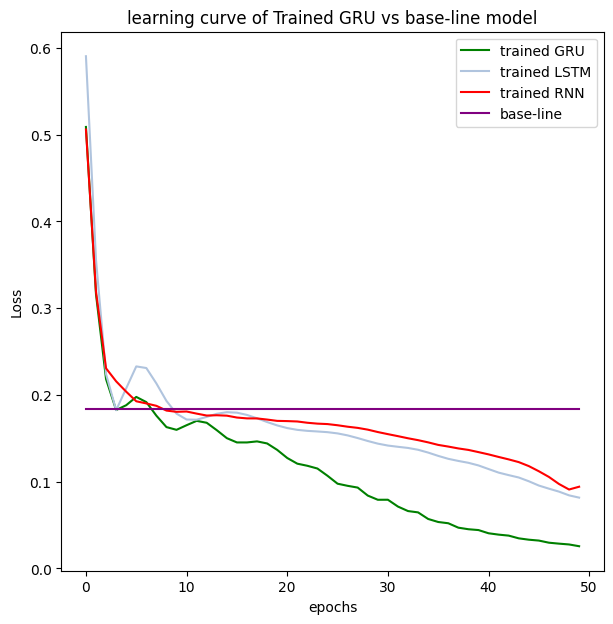

In [29]:
plt.figure(figsize=(7,7))
plt.plot(epoch_count,gru_loss_epoch,color = "green",label = "trained GRU")
plt.plot(epoch_count,lstm_loss_epoch,color = "lightsteelblue",label = "trained LSTM")
plt.plot(epoch_count,rnn_loss_epoch,color = "red",label = "trained RNN")
plt.plot(epoch_count,base_line,color = "purple",label = "base-line")
plt.title("learning curve of Trained GRU vs base-line model")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [30]:
base_line_test_loss = loss_fn(test_label,torch.ones_like(test_label))
base_line_test_loss = base_line_loss.detach()
base_line_test_loss

tensor(0.1844)

# PERFORMANCE OVER TESTING SET

Text(0.5, 1.0, 'Performance of Trained models over Testing set')

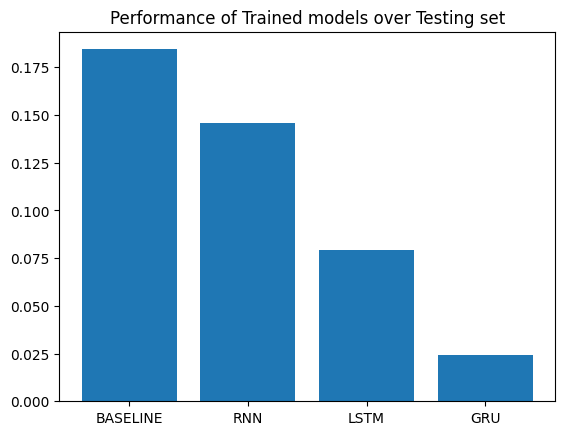

In [31]:
x = ["BASELINE","RNN","LSTM","GRU"]
y = [base_line_test_loss.detach(),rnn_test_loss.detach(),lstm_test_loss.detach(),gru_test_loss.detach()]
plt.bar(x,y)
plt.title("Performance of Trained models over Testing set")

# EXPLAINED VARIANCE COMPARISON

Text(0.5, 1.0, 'Explained variance of Trained models over Testing set')

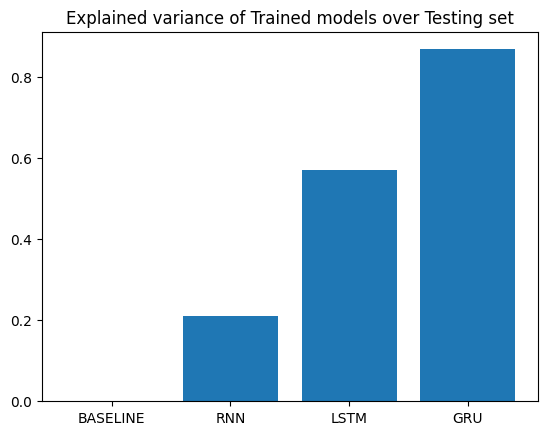

In [32]:
model_loss = torch.tensor([base_line_test_loss.detach(),rnn_test_loss.detach(),lstm_test_loss.detach(),gru_test_loss.detach()])
explained_variance_over_models = 1 - model_loss/base_line_test_loss

x = ["BASELINE","RNN","LSTM","GRU"]
y = [explained_variance_over_models[0],explained_variance_over_models[1],explained_variance_over_models[2],explained_variance_over_models[3]]
plt.bar(x,y)
plt.title("Explained variance of Trained models over Testing set")

In [33]:
end = time.time()
(end - begin)/60

21.479694414138795